### Core

In [1]:
from collections import OrderedDict

### Data science

In [2]:
import numpy as np
import scipy

### Visualization

In [3]:
import matplotlib.pyplot as plt

### MNE

In [4]:
import mne

### HyPyP

In [5]:
%load_ext IPython.extensions.autoreload
%autoreload 2

from hypyp import prep 
from hypyp import analyses
from hypyp import stats
from hypyp import viz


In [6]:

from hypyp.eeg_classes.eeg_dyad import EEGDyad

## Setting Analysis Parameters

We define the frequency bands used in the study. Here we use two bands within the Alpha range. We also use an `OrderedDict` to preserve the order of the bands.

In [7]:
# Define frequency bands as a dictionary
freq_bands = {
    'Alpha-Low': [7.5, 11],
    'Alpha-High': [11.5, 13]
}

# Convert to an OrderedDict to keep the defined order
freq_bands = OrderedDict(freq_bands)
print('Frequency bands:', freq_bands)

Frequency bands: OrderedDict({'Alpha-Low': [7.5, 11], 'Alpha-High': [11.5, 13]})


## Loading Data

In [8]:
import pooch

# Template URL for downloading participant data
URL_TEMPLATE = "https://github.com/ppsp-team/HyPyP/blob/master/data/participant{}-epo.fif?raw=true"

def get_epochs_file_path(idx):
    url = URL_TEMPLATE.format(idx)
    file_name = f"participant{idx}-epo.fif"
    return pooch.retrieve(fname = file_name, url = url, known_hash = None, progressbar = True)

dyad = EEGDyad.from_files(get_epochs_file_path(1), get_epochs_file_path(2))


Reading /home/pfortin/.cache/pooch/participant1-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Reading /home/pfortin/.cache/pooch/participant2-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Dropped 224 epochs: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 101, 104, 105, 106, 107, 108, 109, 110, 111, 1

/home/pfortin/work/ppsp/HyPyP-oo/hypyp/eeg_classes/eeg_dyad.py:189: UserWarning: The 2 epochs objects don't have the same length: 260 != 36
  warnings.warn(f"The 2 epochs objects don't have the same length: {len(self.epo1)} != {len(self.epo2)}")


Since our example dataset was not initially dedicated to hyperscanning, we need to equalize the number of epochs between our two participants.

In [9]:
print('Sampling rate:', dyad.sfreq)

Sampling rate: 500.0


## Preprocessing Epochs

### ICA Correction

We perform Independent Component Analysis (ICA) on the data from both participants to identify and remove artefactual components. First, we compute the ICA using the HyPyP function `ICA_fit` and then choose the relevant components for artefact rejection using `ICA_choice_comp`.

In [10]:
# Compute ICA for each participant with 15 components
dyad.prep_ica_fit(5)



Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': np.float64(0.00010129807784293706)}
0 bad epochs dropped
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 5 components
Computing Extended Infomax ICA
Fitting ICA took 1.1s.
Estimating rejection dictionary for eeg
The rejection dictionary is {'eeg': np.float64(4.747409473367548e-05)}
    Rejecting  epoch based on EEG : ['Fp1', 'F7', 'FT10', 'T8', 'TP10']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10', 'TP10', 'O1']
    Rejecting  epoch based on EEG : ['Fp1', 'FT10']
    Rejecting  epoch based on EEG : ['O1']
4 bad epochs dropped
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by number: 5 components
Computing Extended Infomax ICA
Fitting ICA took 1.2s.


Subject idx: 0


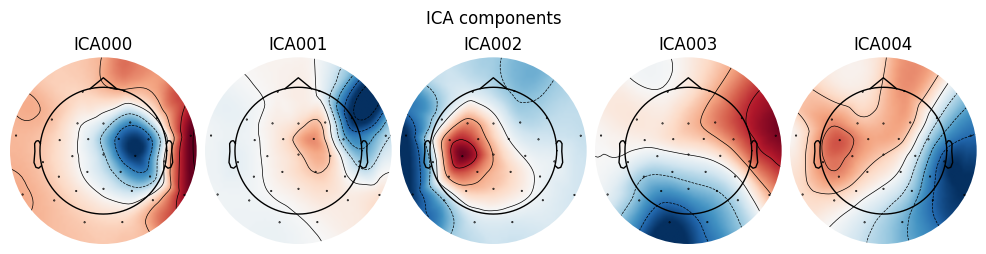

Subject idx: 1


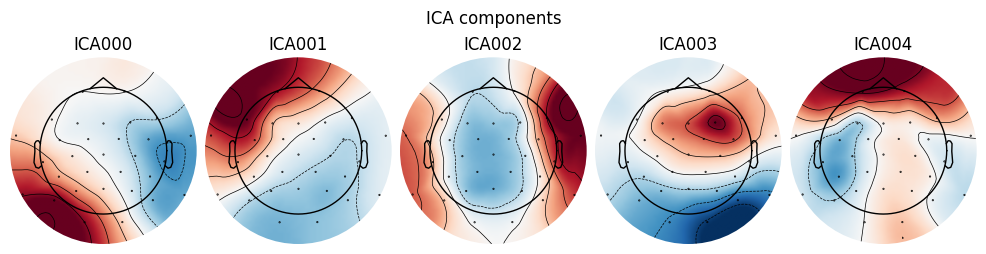

In [11]:
dyad.plot_icas_components()



In [12]:
subject_idx = 1
component_idx = 4

dyad.prep_ica_apply(subject_idx, component_idx)

Median correlation with constructed map: 1.000
No maps selected for subject [0], consider a more liberal threshold.
[{'blink': []}, {'blink': [np.int64(4)]}]
Applying ICA to Epochs instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 31 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 31 PCA components


### Autoreject

In this cell, we apply the local AutoReject algorithm using HyPyP. This step automatically rejects or interpolates bad epochs/channels while ensuring that the same channels/epochs are removed across participants. Verbose output provides a before/after comparison.

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/31 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/31 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=4
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/31 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/31 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/36 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=1
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20


  0%|          | Repairing epochs : 0/28 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Dropped 8 epochs: 0, 1, 3, 4, 5, 6, 9, 20


  0%|          | Repairing epochs : 0/28 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
22.22222222222222 percent of bad epochs
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


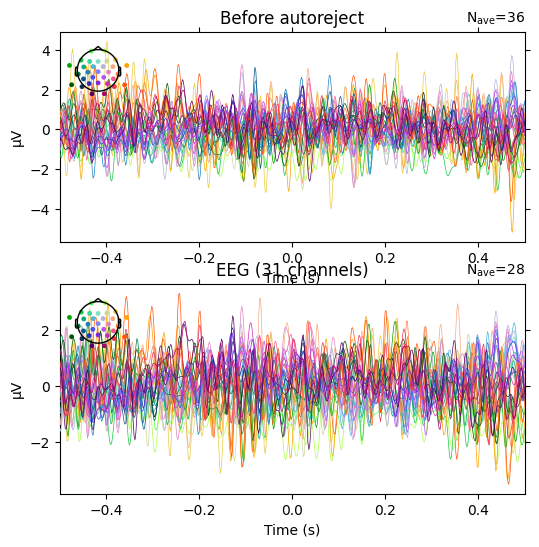

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Figure size 640x480 with 0 Axes>

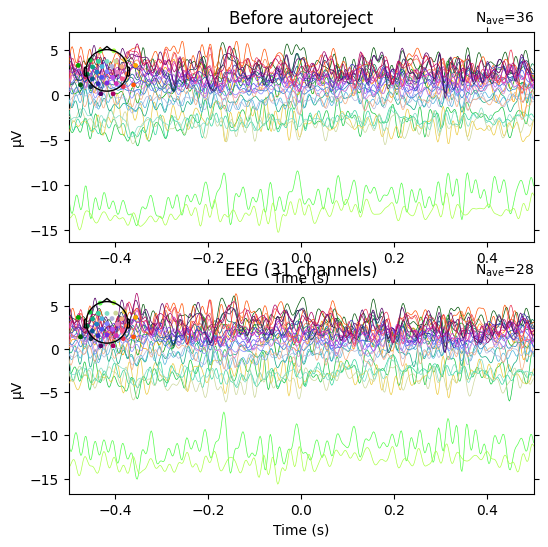

<Figure size 640x480 with 0 Axes>

In [13]:
dyad.prep_autoreject(strategy="union", threshold=50.0, verbose=True)

### Picking Preprocessed Epochs

After cleaning, we separate the preprocessed epochs for each participant for further analysis.

Preprocessed epochs for both participants are ready.


## Analysing Data: Welch Power Spectral Density (PSD)

Here we compute the PSD for each participant in the Alpha-Low band using the HyPyP `analyses.pow` function. The PSD values are averaged across epochs.

In [14]:
# Compute PSD for participant 1 in the Alpha-Low band
dyad.analyse_pow(
    fmin=7.5,
    fmax=11,
    n_fft=1000,
    n_per_seg=1000,
    epochs_average=True
)


Effective window size : 2.000 (s)
Effective window size : 2.000 (s)


## Connectivity Analysis

In this section we compute brain connectivity metrics. 

1. We first compute the analytic signal per frequency band using `analyses.compute_freq_bands`.
2. Then, we compute connectivity (using the 'ccorr' mode) and average across epochs.
3. We slice the resulting connectivity matrices to extract both inter-brain (between participants) and intra-brain (within a participant) connectivity values.
4. A Z-score normalization is performed for illustration purposes.

/home/pfortin/work/ppsp/HyPyP-oo/hypyp/analyses.py:847: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/home/pfortin/work/ppsp/HyPyP-oo/hypyp/analyses.py:847: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/home/pfortin/work/ppsp/HyPyP-oo/hypyp/analyses.py:847: RuntimeWarning: filter_length (575) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mne.filter.filter_data(data[participant],
/home/pfortin/work/ppsp/HyPyP-oo/hypyp/analyses.py:847: RuntimeWarning: filter_length (575) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  filtered = np.array([mn

Alpha-Low


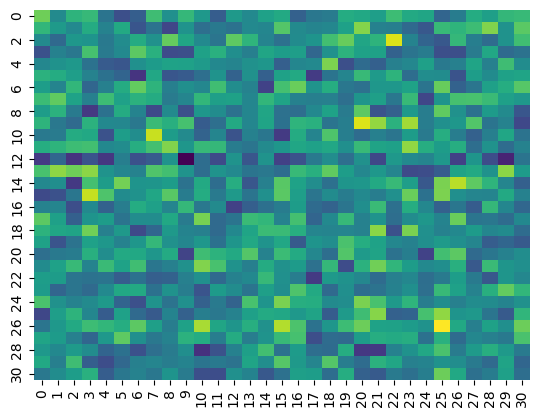

In [24]:
# Prepare data for connectivity analysis (combine both participants)
dyad.compute_complex_signal_freq_bands(freq_bands)

# Compute connectivity using cross-correlation ('ccorr') and average across epochs
dyad.analyse_connectivity('ccorr', epochs_average=True)

# Get connectivity for intra on a specific band
ccorr = dyad.connectivities['ccorr']
freq_band_of_interest = list(freq_bands.keys())[0]
subject_id = 1

inter = ccorr.get_connectivity_for_freq_band(freq_band_of_interest)

inter.plot_zscore()
plt.show()

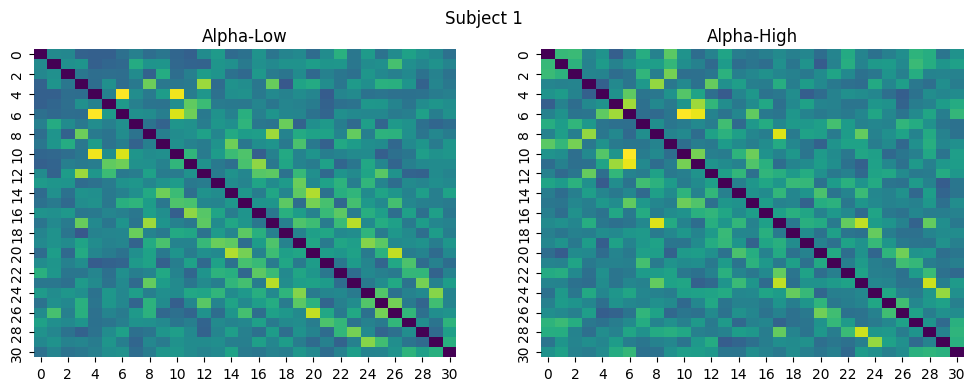

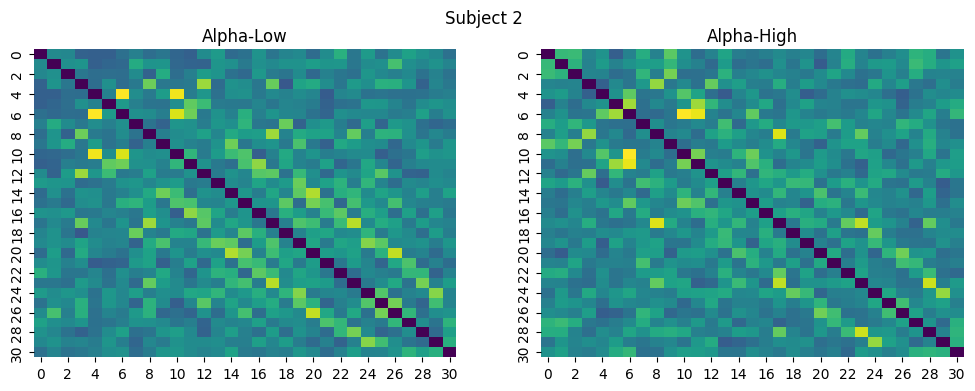

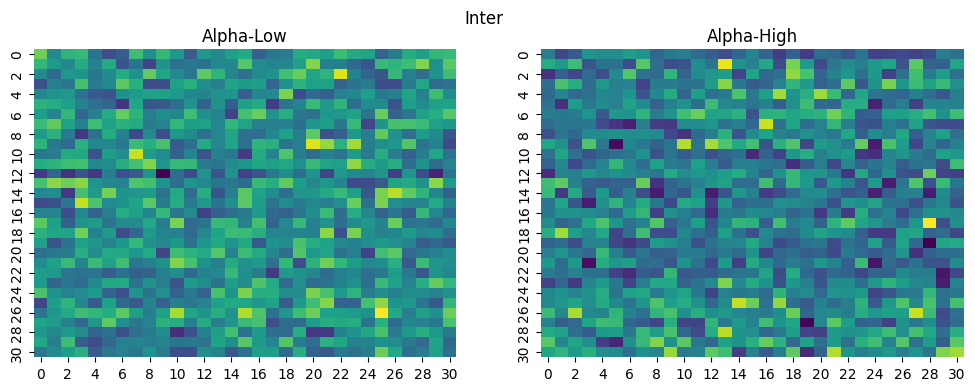

In [ ]:



for row, subject_id in enumerate([1, 2, None]):
    subject_name = 'Inter Subjects'
    if subject_id == 1:
        subject_name = "Intra Subject 1"
    if subject_id == 2:
        subject_name = "Intra Subject 2"

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    for col, freq_band in enumerate(freq_bands.keys()):
        ax = axes[col]

        ccorr.get_connectivity_for_freq_band(freq_band, subject_id).plot_zscore(ax=ax)
        ax.set_title(freq_band)
    fig.suptitle(subject_name)

    plt.show()


## Statistical Analyses

We perform several statistical tests on the computed PSD and connectivity data. These include:

- A parametric permutation t-test on the PSD values.
- Non-parametric cluster-based permutation tests for both PSD and connectivity data.

#### 1/ MNE test without any correction
This function takes samples (observations) by number of tests (variables i.e. channels), thus PSD values are averaged in the frequency dimension


In [15]:
# Compute mean PSD values for each channel across epochs for both participants
psd1_mean = np.mean(psd1.psd, axis=1)
psd2_mean = np.mean(psd2.psd, axis=1)

# Combine the means into a single array for the t-test
X = np.array([psd1_mean, psd2_mean])

# Perform permutation t-test (using MNE) without correction for multiple comparisons
T_obs, p_values, H0 = mne.stats.permutation_t_test(
    X=X,
    n_permutations=5000,
    tail=0,
    n_jobs=1
)
print('Permutation t-test completed.')

# Alternatively, compute statistical conditions using HyPyP's statsCond function
statsCondTuple = stats.statsCond(
    data=data_psd,
    epochs=preproc_S1,
    n_permutations=5000,
    alpha=0.05
)
print('Statistical condition tuple computed.')

Permuting 1 times (exact test)...
Permutation t-test completed.
Permuting 1 times (exact test)...
Statistical condition tuple computed.


### Non-parametric Cluster-Based Permutations

Here, we create a priori connectivity matrices based on sensor positions and then perform cluster-based permutation tests. 

In this example, we create two fake groups (by replicating each participant's PSD data with added noise) and run the permutation test.

In [16]:
# Create connectivity matrix for a priori sensor connectivity using participant 1's sensor layout
con_matrixTuple = stats.con_matrix(preproc_S1, freqs_mean=psd1.freq_list)
ch_con_freq = con_matrixTuple.ch_con_freq

# Create two fake groups by replicating the PSD data and adding a small noise
noise_level = 1e-6  # Small noise to break exact duplicates
data_group = [
    np.array([psd1.psd + np.random.normal(0, noise_level, psd1.psd.shape) for _ in range(3)]),
    np.array([psd2.psd + np.random.normal(0, noise_level, psd2.psd.shape) for _ in range(3)])
]

# Perform non-parametric cluster-based permutation test on the fake groups
statscondCluster = stats.statscondCluster(
    data=data_group,
    freqs_mean=psd1.freq_list,
    ch_con_freq=scipy.sparse.bsr_matrix(ch_con_freq),
    tail=1,
    n_permutations=5000,
    alpha=0.05
)
print('Cluster-based permutation test for PSD completed.')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31
Using a threshold of 7.708647
stat_fun(H1): min=6.183049142351878e-05 max=40.329363753166405
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

Cluster-based permutation test for PSD completed.


### Comparing Intra-Brain Connectivity Between Participants

We now compute a connectivity matrix for intra-brain connectivity and perform a cluster-based permutation test comparing the two participants. 

Again, we generate two fake groups by replicating each participant’s intra-brain connectivity data and adding noise.

Note that for connectivity, values are computed for every integer in the frequency bin from fmin to fmax, freqs_mean=np.arange(fmin, fmax) whereas in PSD it depends on the n_fft parameter psd.freq_list

For CSD, values are averaged across each frequencies so you do not need to take frequency into account to correct clusters

In [17]:
# Create connectivity matrix for intra-brain connectivity
con_matrixTuple = stats.con_matrix(
    epochs=preproc_S1,
    freqs_mean=np.arange(7.5, 11),
    draw=False
)

ch_con = con_matrixTuple.ch_con

# Create fake groups for intra-brain connectivity analysis
Alpha_Low = [
    np.array([
        result_intra[0] + np.random.normal(0, noise_level, result_intra[0].shape),
        result_intra[0] + np.random.normal(0, noise_level, result_intra[0].shape)
    ]),
    np.array([
        result_intra[1] + np.random.normal(0, noise_level, result_intra[1].shape),
        result_intra[1] + np.random.normal(0, noise_level, result_intra[1].shape)
    ])
]

# Run cluster-based permutation test for intra-brain connectivity
statscondCluster_intra = stats.statscondCluster(
    data=Alpha_Low,
    freqs_mean=np.arange(7.5, 11),
    ch_con_freq=scipy.sparse.bsr_matrix(ch_con),
    tail=1,
    n_permutations=5000,
    alpha=0.05
)
print('Intra-brain connectivity cluster test completed.')

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 31
Using a threshold of 18.512821
stat_fun(H1): min=1225712.8253921915 max=371103230211354.56
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

Intra-brain connectivity cluster test completed.


### Comparing Inter-Brain Connectivity to Random Signal

Finally, we compare inter-brain connectivity values to a random signal. In this case, no a priori connectivity matrix is used between the two participants. We again create fake groups and run the permutation test.

In [18]:
# Create fake groups for inter-brain connectivity analysis
data = [
    np.array([
        values, 
        values + np.random.normal(0, 1e-6, values.shape)
    ]), 
    np.array([
        result_intra[0], 
        result_intra[0] + np.random.normal(0, 1e-6, result_intra[0].shape)
    ])
]

print(len(data[0][0]), len(data[0][1]), len(data[1][0]), len(data[1][1]))


# Run cluster-based permutation test for inter-brain connectivity without connectivity priors
statscondCluster = stats.statscondCluster(
    data=data,
    freqs_mean=np.linspace(7.5, 11, data[0].shape[-1]),
    ch_con_freq=None,
    tail=0,
    n_permutations=5000,
    alpha=0.05
)
print('Inter-brain connectivity cluster test completed.')

31 31 31 31
stat_fun(H1): min=5.500175642446024 max=inf
Running initial clustering …
Found 1 cluster


/home/pfortin/work/ppsp/HyPyP-oo/.venv/lib/python3.12/site-packages/mne/stats/parametric.py:174: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

Inter-brain connectivity cluster test completed.


## Visualization

In this final section, we visualize the statistical results and connectivity maps. We use HyPyP visualization functions to:

- Plot sensor-level T-values for all sensors and for only significant sensors.
- Visualize inter-brain connectivity on 2D and 3D head models.
- Visualize intra-brain connectivity for each participant in both 2D and 3D.

Note: We manually specify bad channels for visualization purposes.

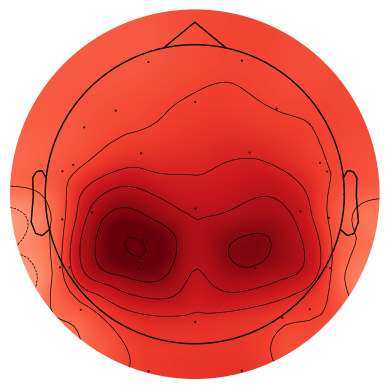

Sensor-level T-values plotted.


In [19]:
# Plot sensor-level T-values using the t-statistics computed earlier
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs,
    epochs=preproc_S1
)
print('Sensor-level T-values plotted.')

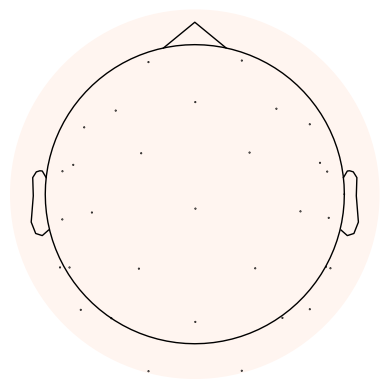

Significant sensors T-values plotted.


In [20]:
# Plot only the T-values for sensors that are statistically significant
viz.plot_significant_sensors(
    T_obs_plot=statsCondTuple.T_obs_plot,
    epochs=preproc_S1
)
print('Significant sensors T-values plotted.')

### Visulization of inter-brain links projected
on either 2D or 3D head models

It can be applied to Cohen’s D (C as done here) or statistical values (statscondCluster.F_obs or F_obs_plot) of inter-individual brain connectivity

We can defining manually bad channel for viz test:

In [21]:
epo1.info['bads'] = ['F8', 'Fp2', 'Cz', 'O2']
epo2.info['bads'] = ['F7', 'O1']

### Visualisation of brain connectivity in 2D and 3D
Defining head model and adding sensors

Warning, threshold='auto' must be used carefully, it is calculated specifically for the dyad, and therefore does not allow comparability between different dyads.

#### Visualization of inter-brain connectivity in 2D

Inter-brain Hilbert-based connectivity

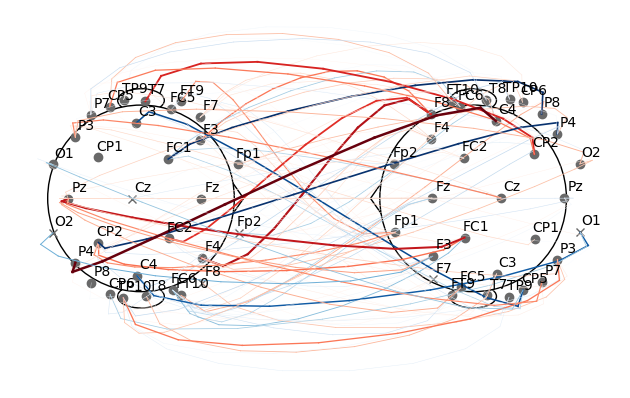

<Axes: >

In [22]:
viz.viz_2D_topomap_inter(epo1, epo2, C, threshold='auto', steps=10, lab=True)

#### Visualization of inter-brain connectivity in 3D

Inter-brain Hilbert-based connectivity


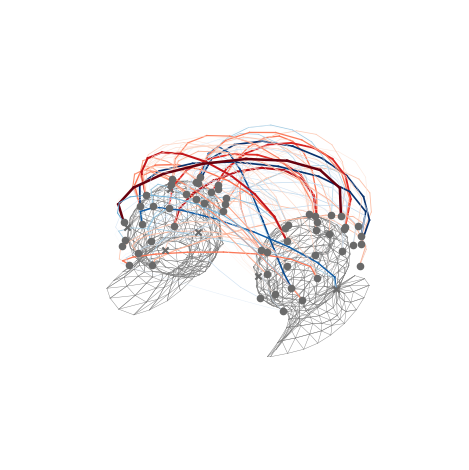

3D inter-brain connectivity visualization completed.


In [23]:
viz.viz_3D_inter(epo1, epo2, C, threshold='auto', steps=10, lab=False)
print('3D inter-brain connectivity visualization completed.')

#### Visualization of intra-brain connectivity in 2D

Intra-brain Hilbert-based connectivity

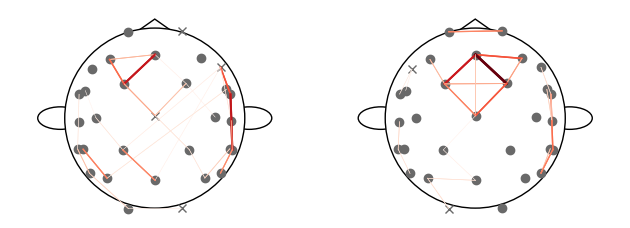

2D intra-brain connectivity map plotted.


In [24]:
viz.viz_2D_topomap_intra(epo1, epo2,
                         C1= result_intra[0],
                         C2= result_intra[1],
                         threshold='auto',
                         steps=2,
                         lab=False)

print('2D intra-brain connectivity map plotted.')

#### Visualization of intra-brain connectivity in 3D

Intra-brain Hilbert-based connectivity

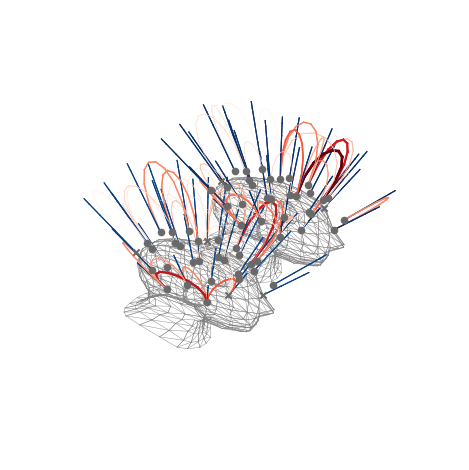

3D intra-brain connectivity visualization completed.


In [25]:
viz.viz_3D_intra(epo1, epo2,
                 C1= result_intra[0],
                 C2= result_intra[1],
                 threshold='auto',
                 steps=10,
                 lab=False,
                )

print('3D intra-brain connectivity visualization completed.')